# Setup and imports

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from pathlib import Path
from tqdm import tqdm
from csbdeep.utils import normalize
from utils import read_czi_image, read_czi_for_napari

# Load train and test images

In [3]:
# Define the directories containing your training/validation images and annotated ground truth pairs
train_img_directory = Path("./train_validation_data/train_data")
test_img_directory = Path("./test_data")

# Create a list containing all file paths .czi input images (train and test)
f_images = sorted(train_img_directory.glob("*.czi")) + sorted(test_img_directory.glob("*.czi"))

#TODO: Problem lies in the way the index position of these filepaths and filenames, it is not ordered according to increasing filename numbering

In [35]:
f_images

[WindowsPath('train_validation_data/train_data/1742I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('train_validation_data/train_data/1799I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('train_validation_data/train_data/1801I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('train_validation_data/train_data/1837I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('train_validation_data/train_data/1849I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('train_validation_data/train_data/1851I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('test_data/1743I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('test_data/1800I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('test_data/1838I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('test_data/1850I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('test_data/1852I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi'),
 WindowsPath('test_data/1853I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ.czi')]

In [6]:
# Read each .czi stack, reshape it into channels-last format, apply percentile-based normalization and append to a tuple
imgs = tuple(normalize(read_czi_image(f, channels=(0,1,2,3)), axis=(0,1)) for f in tqdm(f_images))

100%|██████████| 12/12 [01:15<00:00,  6.29s/it]


# Load the model

In [7]:
import model as M

In [8]:
# Define the model_name you want to use from the models folder
model_name = 'model_gfp_dapi_bcat_lsd1_epoch_100'
# Load the different models here by changing the model name
model = M.UNet(None, model_name, basedir='models')

Loading network weights from 'weights_best.h5'.


In [9]:
model

UNet(model_gfp_dapi_bcat_lsd1_epoch_100): XYC → XYC
├─ Directory: C:\Users\adiezsanchez\githubrepos\UNet_SemSeg_healthy_tumor_SRs\models\model_gfp_dapi_bcat_lsd1_epoch_100
└─ UNetConfig(n_dim=2, axes='XYC', n_channel_in=4, n_channel_out=3, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', probabilistic=False, unet_residual=False, unet_n_depth=2, unet_kern_size=3, unet_n_first=32, unet_last_activation='softmax', unet_input_shape=[None, None, 4], train_loss='categorical_crossentropy', train_epochs=100, train_steps_per_epoch=400, train_learning_rate=0.0004, train_batch_size=4, train_tensorboard=True, train_reduce_lr={'factor': 0.5, 'patience': 10, 'min_delta': 0}, train_class_weight=[1, 1, 1], unet_batch_norm=False, unet_dropout=0.0, patch_size=[512, 512])

# Apply model to obtain predictions, assign classes and store them as uint8 .tiff files

In [19]:
#TODO: Fix the differences in array size between original img and class_assignment/prediction, probably a consequence of tiling or argmax

# Create the necessary folder structure if it does not exist in order to save the predictions after class assignment
prediction_tiff_directory = f"prediction_tiffs/{model_name}"

try:
    os.makedirs(prediction_tiff_directory)
    print(f"Output folder created: {prediction_tiff_directory}")
except FileExistsError:
    print(f"Output folder already exists: {prediction_tiff_directory}").astype(np.uint8)

for img, filepath in zip(imgs, f_images):
    # Extract the filename
    filename = filepath.stem
    # Apply the model to obtain class probabilities
    prediction = model.predict(img, axes='XYC', n_tiles=(8,8,1))
    # Take the argmax along the channel axis to get the class with the highest probability
    class_assignment = np.argmax(prediction, axis=2)
    # Save the assigned classes as a tiff file
    tifffile.imwrite(f"{prediction_tiff_directory}/{filename}.tiff", class_assignment)

Output folder created: prediction_tiffs/model_gfp_dapi_bcat_lsd1_epoch_100


c:\Users\adiezsanchez\miniforge3\envs\EMBL_tensorflow\lib\site-packages\csbdeep\models\base_model.py:311: UserWarning: skipping normalization step after prediction because number of input and output channels differ.
  warnings.warn('skipping normalization step after prediction because ' +
100%|██████████| 64/64 [00:06<00:00,  9.44it/s]


In [27]:
img.shape

(6561, 6561, 4)

In [28]:
prediction.shape

(6561, 6561, 3)

In [29]:
class_assignment.shape

(6561, 6561)

# Display the predictions

In [23]:
# Remove images variable to free up memory
# del imgs

# Add the filepaths to the predicted class .tiffs to a list
f_classes = sorted(Path(prediction_tiff_directory).glob("*.tiff"))

In [34]:
#TODO: Display a single prediction of your choice using Napari, double check issues with index assignment 

import napari

index = 4

viewer = napari.Viewer(ndisplay=2)

input_image = read_czi_for_napari(f_images[index])
predicted_classes = tifffile.imread(f_classes[index])
filename_czi = f_images[index].stem
filename_tiff = f_classes[index].stem

if filename_czi == filename_tiff:
    filename = filename_tiff

viewer.add_image(input_image, name=f"{filename}_mip")
viewer.add_labels(predicted_classes, name=f"{filename}_labels")

<Labels layer '1853I_10X_OP_LGR5GFP_BCAT_DAPI_LSD1_HQ_labels' at 0x1eb4b575610>

In [25]:
input_image.shape

(4, 7506, 7506)

In [26]:
predicted_classes.shape

(6561, 5616)

0it [00:00, ?it/s]

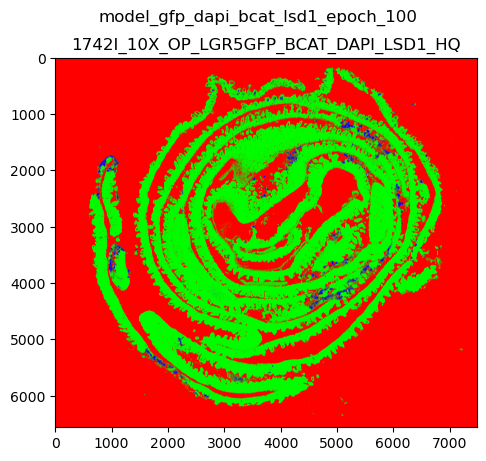

1it [00:04,  4.46s/it]

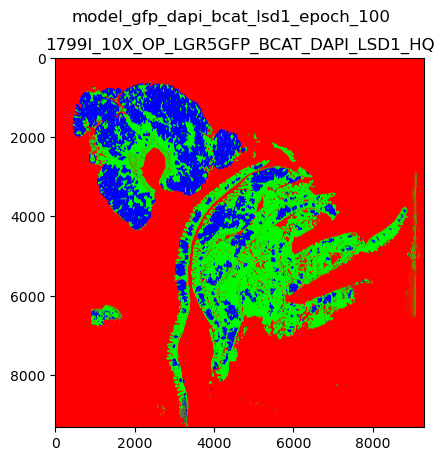

2it [00:11,  5.83s/it]

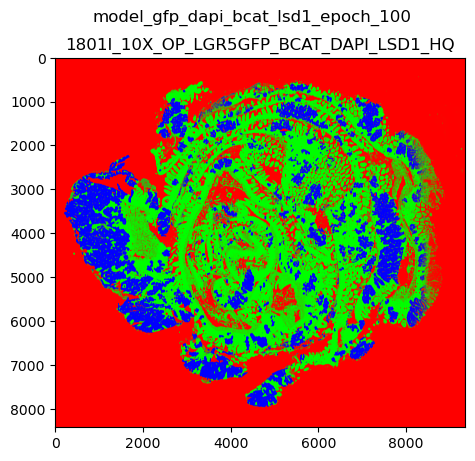

3it [00:17,  6.08s/it]

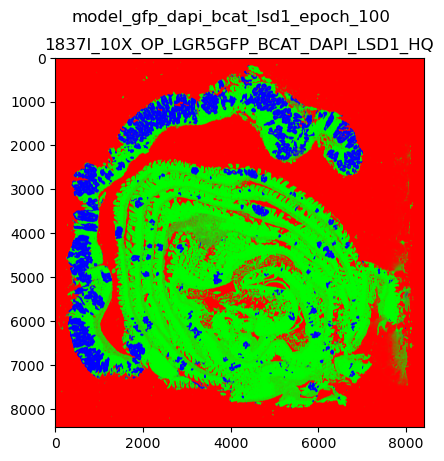

4it [00:23,  5.97s/it]

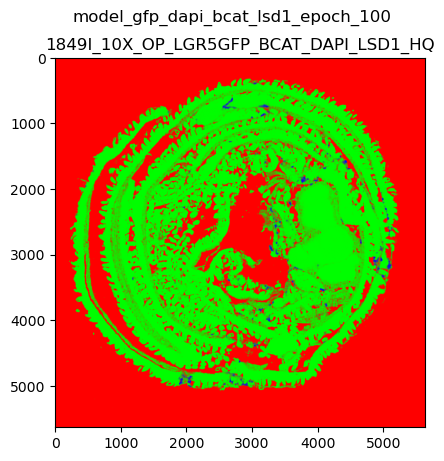

5it [00:26,  5.04s/it]

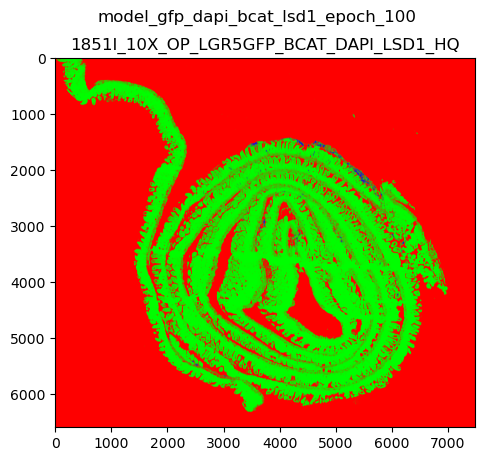

6it [00:31,  4.85s/it]

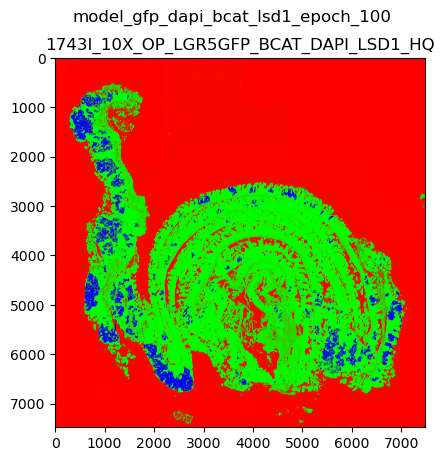

7it [00:36,  4.81s/it]

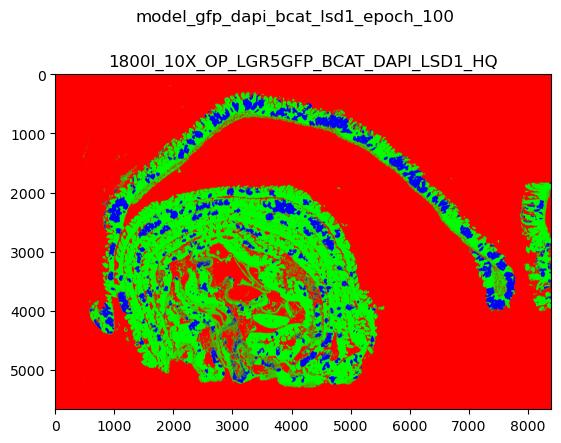

8it [00:40,  4.68s/it]

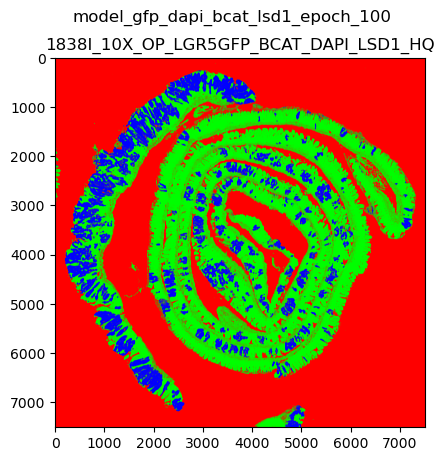

9it [00:45,  4.77s/it]

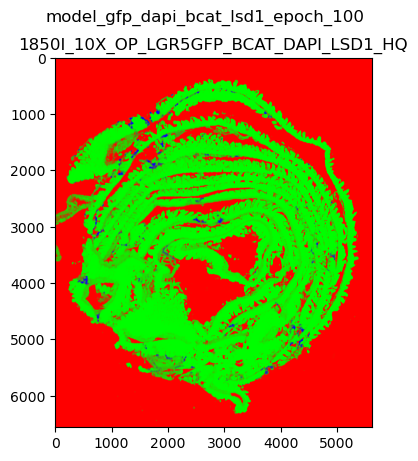

10it [00:48,  4.37s/it]

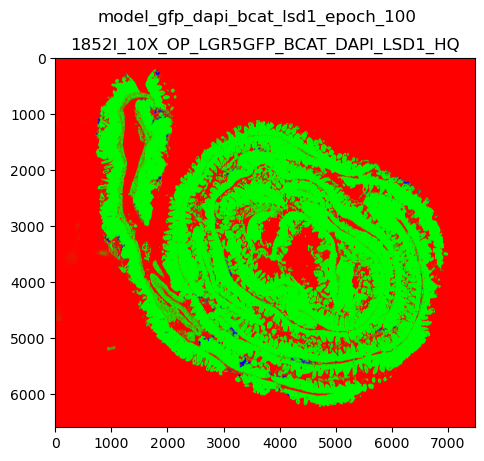

11it [00:53,  4.41s/it]

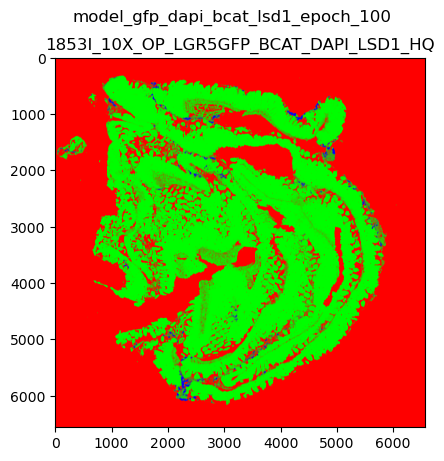

12it [00:57,  4.78s/it]


In [12]:
prediction_png_directory = f"prediction_pngs/{model_name}"

# Create the necessary folder structure if it does not exist
try:
    os.makedirs(prediction_png_directory)
    print(f"Output folder created: {prediction_png_directory}")
except FileExistsError:
    print(f"Output folder already exists: {prediction_png_directory}")

# Loop through all the predictions, display and store them
for i, img in tqdm(enumerate(predictions)):
    img = predictions[i]
    plt.imshow(img)
    plt.suptitle(model_name)
    plt.title(f_images[i].stem)
    # Save the resulting prediction matplotlib plots
    plt.savefig(fname=f"prediction_pngs/{model_name}/{f_images[i].stem}.png", dpi=300, format='png')
    plt.show()

# Save predictions as tiff files